In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os

In [80]:
home = os.path.expanduser("~")
sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [81]:
speeds = np.asarray([0.1,0.2,0.3,0.4,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
speeds = speeds[::2]

In [82]:

def bar(t, xc, b = 0.160, v = 1):

    if xc >=-b+v*t and xc <=b+v*t :
        return 1
    else: 
        return 0
    

# load RAM simulations

In [83]:
data = {}
cell = 50
# nets_list = ['Reciporcal_fitted/wBA/wBA_31.0',
#              'Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/wBA/wBA_31.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
#              'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
#              'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',]


nets_list = ['Reciporcal_fitted/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_31.0',
             'Reciporcal_fitted_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_mono_linear/noGCGainControl/wBA/wBA_0.0',
             'Reciporcal_fitted/noGCGainControl/wBA/wBA_0.0',]


nets_list = ['Reciporcal_mono_linear_plastic_opt/noGCGainControl/fixed/wBA/wBA_0.0',
             'Reciporcal_mono_linear_plastic_opt/noGCGainControl/fixed/wBA/wBA_46.0' ]



nets_list = ['ff_linear/wGA/wGA_0.0',
             'ff_linear/wGA/wGA_0.0126' ]


for net in nets_list:
    
    data[net] = {}

    bars = []
    tps_rf_GC_mid = []
    times = []

    Fs = []
    RBs = []
    RAs = []
    RGs = []
    VGs = []

    peaks_RG = []
    peaks_RB = []
    peaks_drive = []

    amps_RB = []
    amps_RA = []
    amps_RG = []
    amps_drive = []

    ants_RB_drive = []
    ants_RB_bar = []

    ants_RG_drive = []
    ants_RG_bar = []
    ants_drive = []


    for s in speeds: 
        fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}/smooth_{s}'
        with open(f'{fp}/out_smooth', 'rb') as handle:
            out = pickle.load(handle)    
            
        with open(f'{fp}/params', 'rb') as handle:
            paramsi = pickle.load(handle)
            
        duration = paramsi['duration']
        dt = paramsi['dt']
        time = np.arange(0,duration,dt)    # - (paramsi['spacing']*cell)/paramsi['speed']#*1000#+45
        mid_cell = int( paramsi['nb_GC_cells']/2 )
        pos_cell = paramsi['pos_rf_GC_mid'][mid_cell]
        barr = [bar(t,pos_cell, v = s) for t in time]
        tp_bar = paramsi['tps_rf_GC_mid'][mid_cell]

        peak_RB = time[np.argmax(out['RB'][50,:])]
        peak_RG = time[np.argmax(out['RG'][:])]
        peak_drive = time[np.argmax(out['inp'][:])]

        amp_RB = np.max(out['RB'][50,:])
        amp_RA = np.max(out['RA'][50,:])
        amp_RG = np.max(out['RG'][:])
        amp_drive = np.max(out['inp'][:])

        

        # RAM
        ant_RB_drive =  peak_drive - peak_RB
        ant_RB_bar  =  tp_bar - peak_RB

        ant_RG_drive =  peak_drive - peak_RG
        ant_RG_bar =  tp_bar - peak_RG
    
        ant_drive =  tp_bar - peak_drive

        bars.append(barr)
        tps_rf_GC_mid.append(tp_bar)
        times.append(time)

        Fs.append(out['inp'])
        RBs.append(out['RB'][50,:])
        RAs.append(out['RA'][50,:])
        VGs.append(out['VG'])
        RGs.append(out['RG'])

        peaks_RB.append(peak_RB)
        peaks_RG.append(peak_RG)
        peaks_drive.append(peak_drive)

        amps_RB.append(amp_RB)
        amps_RA.append(amp_RA)
        amps_RG.append(amp_RG)
        amps_drive.append(amp_drive)

        ants_RB_drive.append(ant_RB_drive)
        ants_RB_bar.append(ant_RB_bar)
        
        ants_RG_drive.append(ant_RG_drive)
        ants_RG_bar.append(ant_RG_bar)
        ants_drive.append(ant_drive)


    
    data[net]['peaks']={}
    data[net]['peaks']['RB'] = np.asarray(peaks_RB)
    data[net]['peaks']['RG'] = np.asarray(peaks_RG)
    data[net]['peaks']['drive'] =np.asarray( peaks_drive)  

    data[net]['amps']={}
    data[net]['amps']['RB'] = np.asarray(amps_RB)
    data[net]['amps']['RA'] = np.asarray(amps_RA)
    data[net]['amps']['RG'] = np.asarray(amps_RG)
    data[net]['amps']['VG'] = np.asarray(amps_RG)
    data[net]['amps']['drive'] =np.asarray( amps_drive)

    data[net]['ants'] ={}
    data[net]['ants']['RB_drive'] =np.asarray(ants_RB_drive)
    data[net]['ants']['RB_bar'] =np.asarray(ants_RB_bar)
    data[net]['ants']['RG_drive'] =np.asarray(ants_RG_drive)
    data[net]['ants']['RG_bar'] =np.asarray(ants_RG_bar)
    data[net]['ants']['drive'] =np.asarray(ants_drive)
    
    data[net]['RB'] = RBs
    data[net]['RA'] = RAs
    data[net]['RG'] = RGs
    data[net]['VG'] = VGs
    data[net]['F'] = Fs


    data['bars'] = bars
    data['tps_rf_mid'] = np.asarray(tps_rf_GC_mid)
    data['times'] = times


In [84]:
net = nets_list[1]
net_pool = nets_list[0]

# Figure Parameter

In [85]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


# anticipation mechanism RAM

In [86]:
%matplotlib inline

0.8


Text(0.5, 0, 'time [s]')

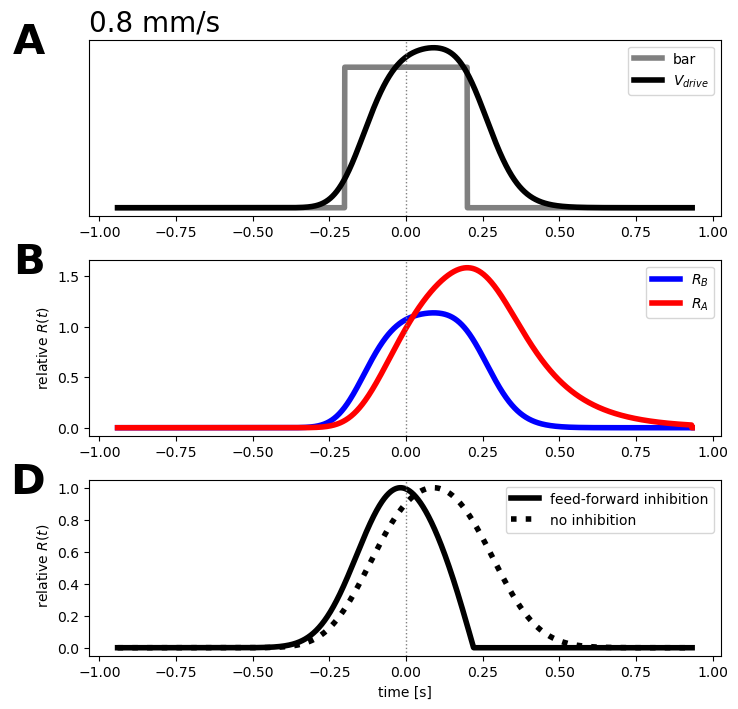

In [88]:
cbar = 'grey'
c1 = 'blue'
c2 = 'red'
speed_plot = -7
print(speeds[speed_plot])

#initialize figure
nrows = 3
ncols = 1

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)



fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.25,
wspace=0.48)





ax = fig.add_subplot(gs[0])
ax.set_title(f'{speeds[speed_plot]} mm/s', fontsize = fontsize_legend, loc='left')

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



time = data['times'][speed_plot]
barr = [bar(t,pos_cell, v = speeds[speed_plot]) for t in time]

xdata = time  - pos_cell/speeds[speed_plot]
ax.plot(xdata ,barr, linewidth = lw, color = cbar, label = 'bar')
ax.plot(xdata,data[net]['F'][speed_plot]/np.max(data[net]['F'][-1]), label = '$V_{drive}$', color = 'k', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
#ax.set_ylabel('$V(t)')
ax.legend()
ax.set_yticks([])


ax = fig.add_subplot(gs[1])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



RB =data[net]['RB'][speed_plot]
RA =data[net]['RA'][speed_plot]   

ax.plot(xdata,RB/np.max(data[net]['RB'][-1]), color = c1, linewidth = lw, label = '$R_{B}$')
#ax.plot(xdata,RB, color = c1, linewidth = lw)

ax.plot(xdata,RA/np.max(data[net]['RA'][-1]), color = c2, linewidth = lw, label = '$R_{A}$')
#ax.plot(xdata,RA, color = c2, linewidth = lw)

# ax.plot(xdata,data[net_pool]['RB'][speed_plot]/np.max(data[net_pool]['RB'][-1]), label = '$R_{B}$ bipolars only', color = c1, linestyle = ':', linewidth = lw)
#ax.plot(xdata,data[net_pool]['RB'][speed_plot], label = f'RB without lateral connectivity', color = c1, linestyle = ':', linewidth = lw)

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('relative $R(t)$')
ax.legend()


# # add panel with all BC responses that the GC pools over
# ax = fig.add_subplot(gs[2])


# ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
#           fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

# # get BC cells that the GC pools from 
# rf = DOG(paramsi['pos_rf_mid'],paramsi['pos_rf_mid'][cell],paramsi['std_GC'], paramsi['std_GC_s'], paramsi['w_GC'])
# #rf = DOG(self.pos_rf_mid,self.pos_rf_GC_mid[i],self.std_GC,self.std_GC_surround,self.w)

# BC_cells = []
# BC_pos = []
# BC_cells_weight = []

# for p,val in enumerate(rf):
#     if val >= 0.01:
#         BC_cells.append(p)
#         BC_pos.append((paramsi['pos_rf_mid'][p]-paramsi['pos_rf_mid'][cell])*100)
#         BC_cells_weight.append(val)

# #ax[0.scatter(BC_cells,rf[BC_cells])
# print(BC_pos)
# BC_cells= np.asarray(BC_cells)- cell
# BC_cells = BC_cells.astype(int)
# BC_cells_weight = np.asarray(BC_cells_weight)

# BC_cells_short = BC_cells[0::12]
# BC_pos_short = np.asarray(BC_pos[0::12])
# BC_cells_weight_short = BC_cells_weight[0::12]
# print(BC_cells_short)

# cmap = plt.get_cmap('Blues', len(BC_cells_short))
# cmapA = plt.get_cmap('Reds', len(BC_cells_short))


# for i,c in enumerate(BC_cells_short):

#     r =  out['RB'][50 + c] *BC_cells_weight_short[i] 
#     rA =  out['RA'][50 + c] *BC_cells_weight_short[i] 

#     #ax.plot(r,linewidth = lw,  color = 'blue', alpha = (1-np.abs(c*0.01))-0.5)
#     ax.plot(r,linewidth = lw,  color = cmap(i), label = f'{np.round(BC_pos_short[i])}')
#     ax.plot(rA,linewidth = lw,  color = cmapA(i), label = f'{np.round(BC_pos_short[i])}')

# #ax.legend()
# cbar_ax = fig.add_axes([.78, .4, .1, .03])
# cNorm = colors.Normalize(vmin =BC_pos_short.min(), vmax = BC_pos_short.max())
# cmap = plt.get_cmap('hsv', 100)

# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
# fig.colorbar(scalarMap,
#              cax=cbar_ax, orientation='horizontal', label='position [$\mu m$]')


# ax.set_ylabel('$w_{i} R{i}_{B}(t)$')


ax = fig.add_subplot(gs[2])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "D", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


RG_pool =data[net_pool]['RG'][speed_plot]
RG =data[net]['RG'][speed_plot]
ax.plot(time - pos_cell/speeds[speed_plot],RG/RG.max(), color = 'k', linewidth = lw, label = 'feed-forward inhibition')
ax.plot(time - pos_cell/speeds[speed_plot],RG_pool/RG_pool.max(), linestyle = ':', color = 'k', linewidth = lw, label = 'no inhibition')

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.legend()
ax.set_ylabel(' relative $R(t)$')
ax.set_xlabel('time [s]')


# speed scaling

Text(0, 0.5, 'anticipation [$mm$]')

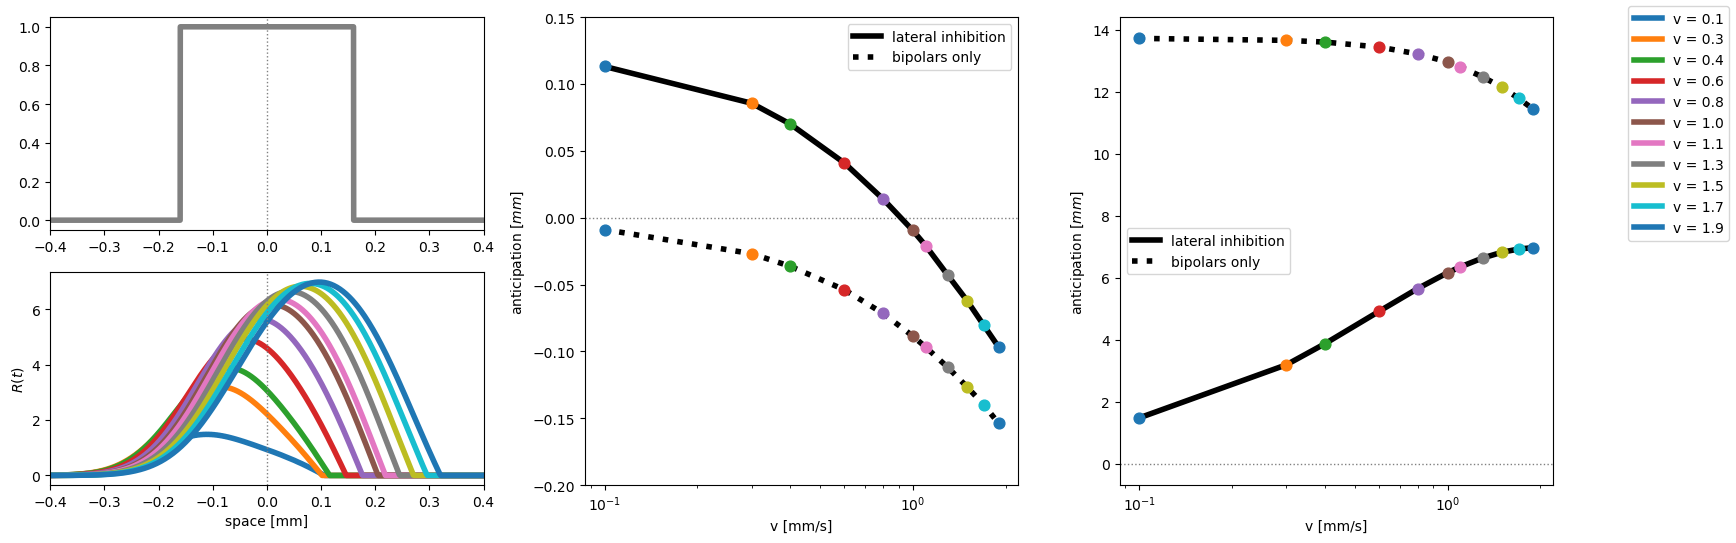

In [59]:
#initialize figure
nrows = 2
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')



fig.subplots_adjust(top=0.975,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)



gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,0:2])

    #add panel labels

    #remove frames that are not needed


x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RG'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()


ax = fig.add_subplot(gs[:,2:4])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RG_bar'] * speeds
antis_pool = data[net_pool]['ants']['RG_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.2,.15)
ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('anticipation [$mm$]')




ax = fig.add_subplot(gs[:,4:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['RG'] 
antis_pool = data[net_pool]['amps']['RG'] 

ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('anticipation [$mm$]')


Text(0, 0.5, 'R [$Hz$]')

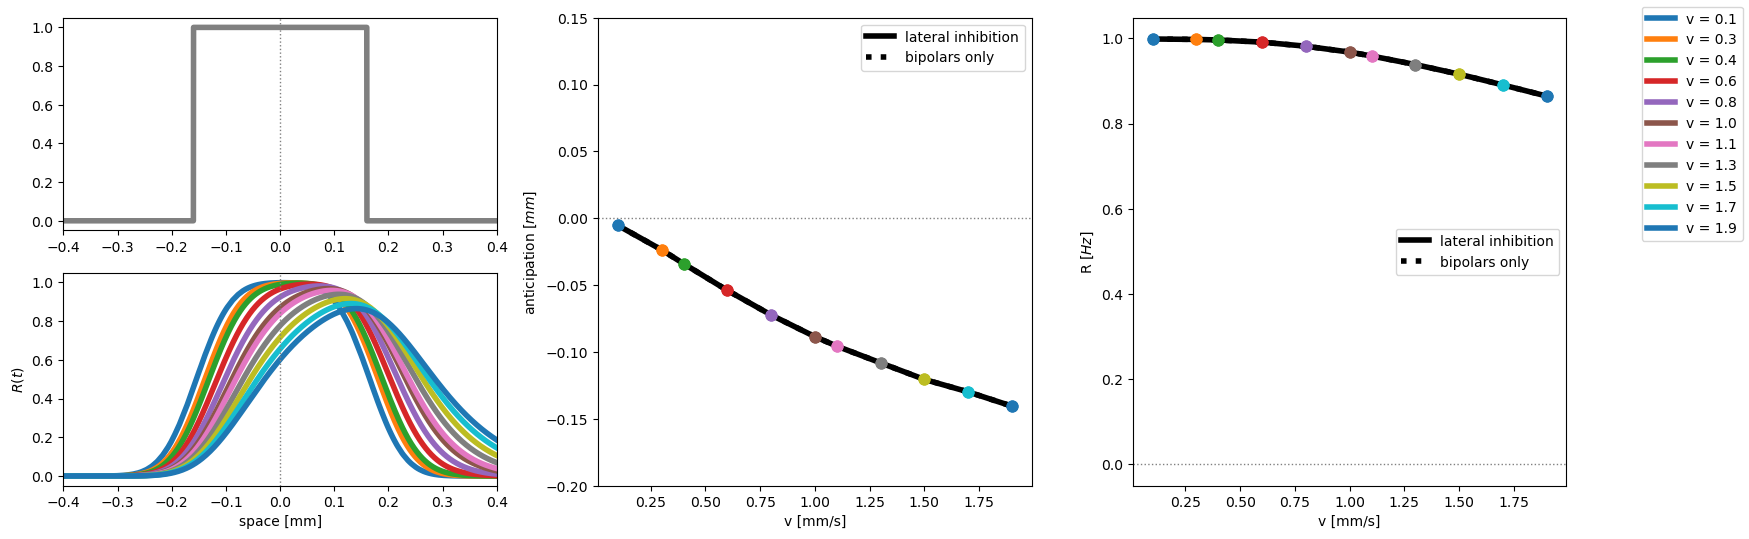

In [60]:
#initialize figure
nrows = 2
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.975,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)



gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,0:2])

    #add panel labels

    #remove frames that are not needed


x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['RB'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()
ax = fig.add_subplot(gs[:,2:4])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['RB_bar'] * speeds
antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('anticipation [$mm$]')





ax = fig.add_subplot(gs[:,4:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['RB'] 
antis_pool = data[net_pool]['amps']['RB'] 


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('R [$Hz$]')


Text(0, 0.5, 'R [$Hz$]')

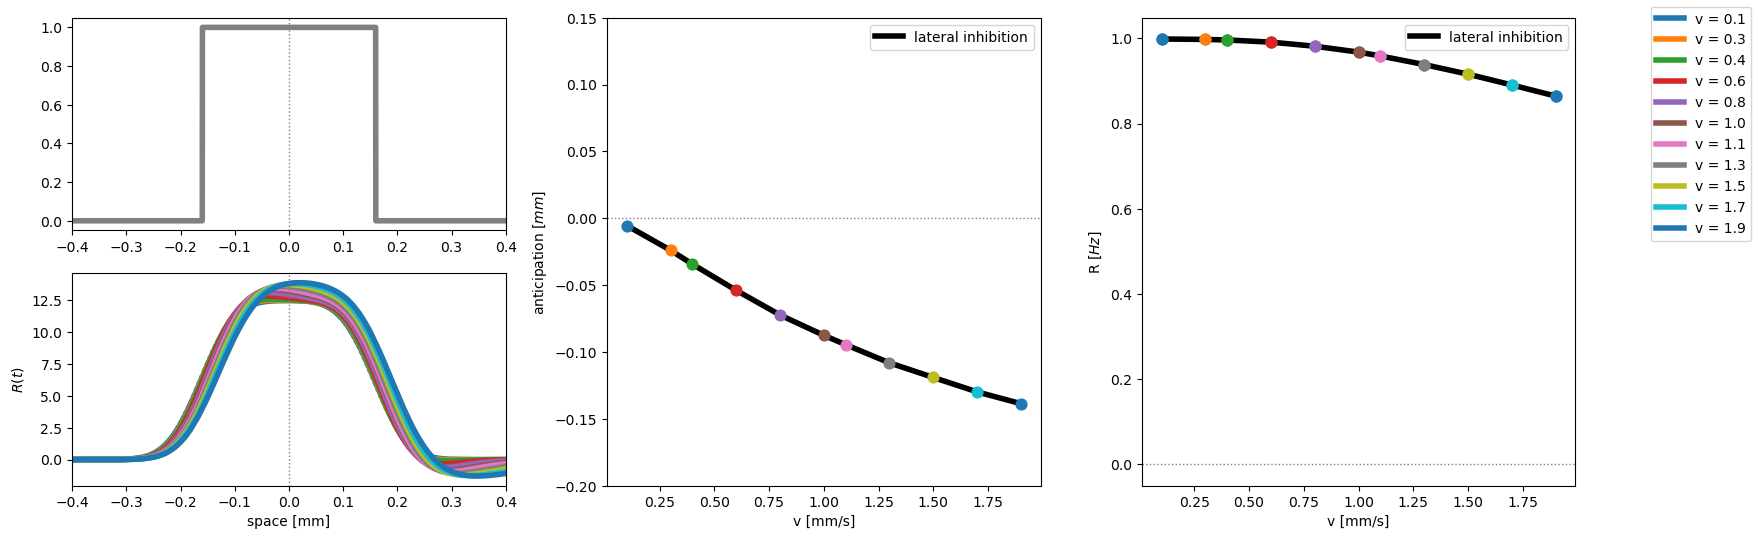

In [61]:
#initialize figure
nrows = 2
ncols = 6

fig = plt.figure(figsize=(ncols*figsize_ratio,nrows*figsize_ratio))
fig.patch.set_facecolor('white')


fig.subplots_adjust(top=0.975,
bottom=0.195,
left=0.065,
right=0.9,
hspace=0.2,
wspace=0.61)



gs = fig.add_gridspec(nrows,ncols)


ax = fig.add_subplot(gs[0,0:2])

    #add panel labels

    #remove frames that are not needed


x = 0

ti = data['times'][x]
barr = [bar(t,pos_cell, v = speeds[x]) for t in ti]
ax.plot(ti*speeds[x]  - pos_cell ,barr, linewidth = lw, color = cbar)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')


ax = fig.add_subplot(gs[1,0:2], sharex = ax)
for x,si in enumerate(speeds[:]):
    ti = data['times'][x]*si
    RG = data[net]['F'][x]
    ax.plot(ti  - pos_cell, RG, label = f'v = {si}', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_xlabel('space [mm]')
ax.set_ylabel('$R(t)$')
ax.set_xlim(-0.4,0.4)
fig.legend()
ax = fig.add_subplot(gs[:,2:4])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['ants']['drive'] * speeds
# antis_pool = data[net_pool]['ants']['RB_bar'] * speeds


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    # ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('anticipation [$mm$]')





ax = fig.add_subplot(gs[:,4:])

ax.axhline(0, linewidth = 1, color = cbar, linestyle = ':')
antis = data[net]['amps']['RB'] 
antis_pool = data[net_pool]['amps']['RB'] 


ax.plot(speeds,antis, color = 'k', linewidth = lw, label = 'lateral inhibition')
# ax.plot(speeds,antis_pool, color = 'k', linewidth = lw,linestyle = ':', label = 'bipolars only')
for x,si in enumerate(speeds[:]):
    p = ax.scatter(speeds[x],antis[x], s= ms, zorder = 10)
    ax.scatter(speeds[x],antis_pool[x], alpha = 1, color = p.get_facecolors(), s = ms, zorder = 10)
ax.legend()


#col = p.get_facecolors()[idx].tolist()
# ax.set_ylim(-.2,.15)
#ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('R [$Hz$]')
